# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [35]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [37]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [38]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**ВЫВОДЫ ПО ДАННЫМ**
- Есть пропуски в данных
- Средняя стоимость авто  2700 (долларов/евро?)
- Максимальное значение мощности авто в л.с.  20 000 (можно в космос лететь)
- Минимальный год регистрации автомобиля - 1000, а макс - 9999 (назад в будущее какое-то)
- Кажется у нас появилось 13 месяецев в году. Если первый месяц 0, то последний будет 11, а не 12. 
- Есть несколько столбцов, которые в анализе не понадобятся, удалим их ( DateCrawled', 'DateCreated', 'LastSeen','NumberOfPictures', 'PostalCode')

Предлагаю для начала убрать не нужные столбцы 

In [39]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen','NumberOfPictures', 'PostalCode'], axis =1)

Теперь подумаем, что делать с данными столбцами:

- столбцы VehicleType, Gearbox, Model, FuelType заполним пропуски по моде
- NotRepaired: Для всех значений NaN установим значение 'yes' or 'no' посмотрим на объём пропущенных значений. (потом посмотрел объём пропущенных значений и выставим 'no', так как мне кажется владельцы просто скрыли факт ремонта. 

In [40]:
data.info()

<AxesSubplot:>

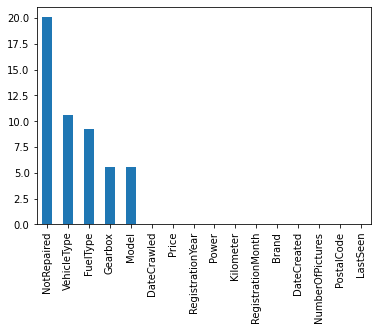

In [41]:
(data.isna().sum().sort_values(ascending = False)/ data.shape[0] * 100).plot(kind = 'bar')

Тэкс, столбццы помимо первых 5 вероятнее всего имеют проблемы с выгрузкой. Заполним их пропуски по моде

In [42]:
data['NotRepaired'] = data['NotRepaired'].fillna('no')
data['VehicleType'] = data['VehicleType'].fillna(data['VehicleType'].mode().values[0])
data['Gearbox'] = data['Gearbox'].fillna(data['Gearbox'].mode().values[0])
data['Model'] = data['Model'].fillna(data['Model'].mode().values[0])
data['FuelType'] = data['FuelType'].fillna(data['FuelType'].mode().values[0])

In [43]:
objects_columns = ["VehicleType","Gearbox","Model","FuelType","Brand","NotRepaired"]
for column in objects_columns:
    print(column, pd.Series(data[column].unique()).str.lower().duplicated().sum())

VehicleType 0
Gearbox 0
Model 0
FuelType 0
Brand 0
NotRepaired 0


Проверим дубликаты и удалим при необходимости 

In [44]:
data.duplicated().sum()

5

In [45]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Удаляем столбцы, которые нам не понадобятся для построения модели

In [46]:
data['DateCrawled'].describe(include='object')

count                  354364
unique                 271174
top       2016-03-24 14:49:47
freq                        7
Name: DateCrawled, dtype: object

In [47]:
data['DateCrawled'].unique()

array(['2016-03-24 11:52:17', '2016-03-24 10:58:45',
       '2016-03-14 12:52:21', ..., '2016-03-21 09:50:58',
       '2016-03-14 17:48:27', '2016-03-19 18:57:12'], dtype=object)

In [48]:
display(data['DateCrawled'])

0         2016-03-24 11:52:17
1         2016-03-24 10:58:45
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
                 ...         
354364    2016-03-21 09:50:58
354365    2016-03-14 17:48:27
354366    2016-03-05 19:56:21
354367    2016-03-19 18:57:12
354368    2016-03-20 19:41:08
Name: DateCrawled, Length: 354364, dtype: object

In [49]:
data.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354364,354364,354364,354364,354364,354364,354364,354364,354364
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,128946,288081,48937,249244,77012,318311,13718,17


In [50]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen','NumberOfPictures', 'PostalCode'], axis =1)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354364 non-null  int64 
 1   VehicleType        354364 non-null  object
 2   RegistrationYear   354364 non-null  int64 
 3   Gearbox            354364 non-null  object
 4   Power              354364 non-null  int64 
 5   Model              354364 non-null  object
 6   Kilometer          354364 non-null  int64 
 7   RegistrationMonth  354364 non-null  int64 
 8   FuelType           354364 non-null  object
 9   Brand              354364 non-null  object
 10  NotRepaired        354364 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Посмотрим на некоторые значения болеле информативно на всякий случай (например Gearbox как хотел)


In [52]:
def make_info (index, title):
    result = pd.DataFrame(data.pivot_table(index = index, aggfunc = 'size').sort_values(ascending = False)).head(10)
    result.columns = ['count']
    plt.figure(figsize = (15,9))
    plt.title(title)
    sns.barplot(x='count', y = result.index, data= result)

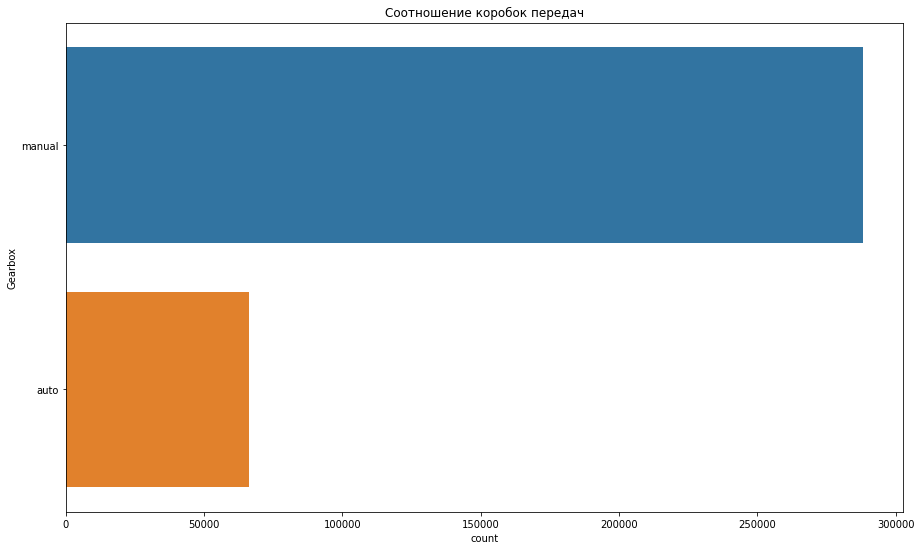

In [53]:
make_info('Gearbox', 'Соотношение коробок передач')

Все таки ручник у нас преобладает, не зря проставили пропущенные значния на 'no'

Предлагаю посмотреть на остальные параметры 

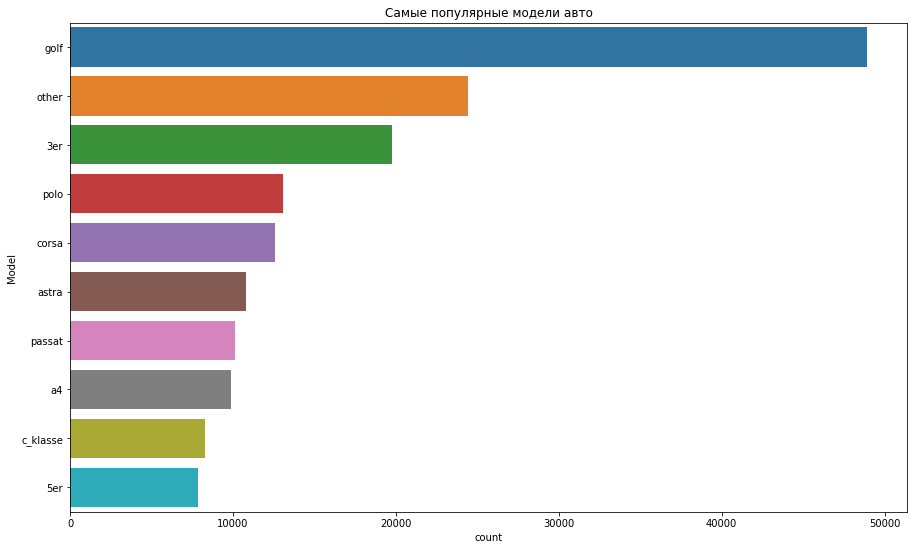

In [54]:
make_info('Model', 'Самые популярные модели авто')

Не хило вырвался гольф вперед

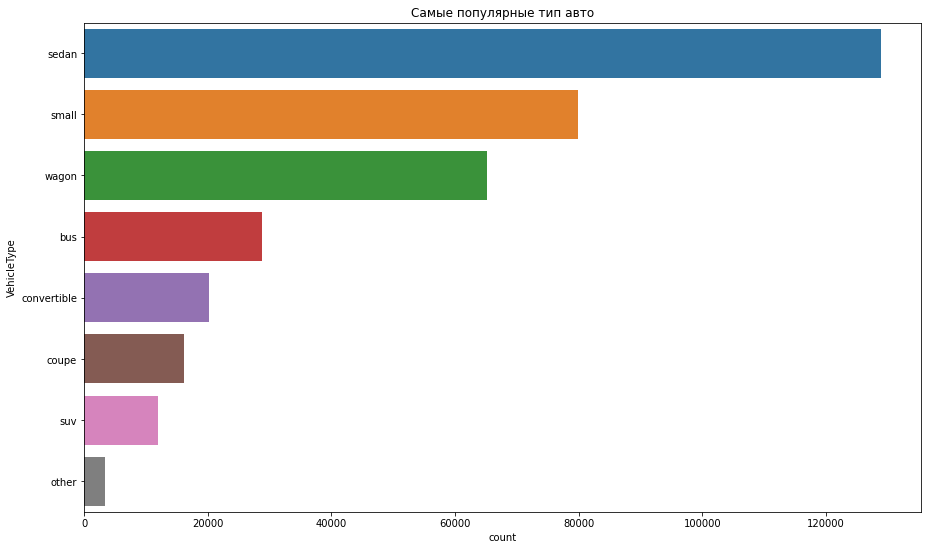

In [55]:
make_info('VehicleType', 'Самые популярные тип авто')

Самой поплуяоглй моделью оказался седан

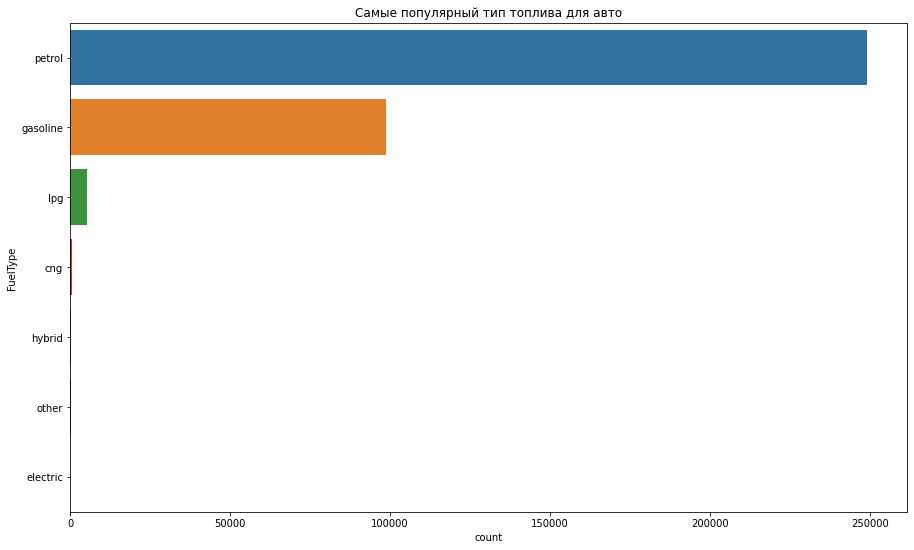

In [56]:
make_info('FuelType', 'Самые популярный тип топлива для авто')

Бензин, очевидно, в лидерах

Такс, с визуализацией какой-никакой покончили, можно попробовать обработать значения в признаках:
- RegistrationYear с годом регистрации предлагаю поступить так. Установить границы с 1940 до 2022 года, так как считаю, что с того времени могли продавать ещё какие-то раритетные экземпляры, но до если и есть, то единичные случаи
- RegistrationMonth поменяем значение 0 на 1, чтобы у нас стало 12 месяцев
- Power  тут есть анломальные значения, предлагаю ограничить их значением в 1600 (если верить гуглу, то это макс. кол-во л.с для авто)
- Price  посмотрим на цена и выбросы


Год регистрации

In [57]:
def reg_year(value):
    if value >2016:
        return 2016
    if value <1940:
        return 1940
    else:
        return value
data['RegistrationYear'] = data['RegistrationYear'].apply(reg_year)

Месяц регистрации

In [58]:
data.loc[data['RegistrationMonth'] ==0, 'RegistrationMonth'] =1
#data['RegistrationMonth']

Мощь авто

In [59]:
data.loc[data['Power'] > 1600, 'Power'] = 1600

In [60]:
def clear_columns (data, column):
    q25 = np.array(data[column].quantile(0.25))
    
    q75 = np.array(data[column].quantile(0.75))
    first_part = q25 -1.5*(q75-q25)
    second_part = q75 + 1.5*(q75-q25)
    row = []
    for index_value, value in zip(data[column].index,data[column]):
        if second_part <= value or value <= first_part:
            row.append(index_value)
    print('Кол-во строк для удаления:'+str(column)+':', len(row))
    return row

In [61]:
array_num_col = ["Price","Power"]
count = 0 
for column in array_num_col:
    index_del = clear_columns(data,column)
    count += len(index_del)
    data = data.drop(index_del,axis = 0)
print("Было удалено:", count)

Кол-во строк для удаления:Price: 18979
Кол-во строк для удаления:Power: 5153
Было удалено: 24132


In [62]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.374707,0.433664,-0.279190,0.108351
RegistrationYear,0.374707,1.000000,0.096034,-0.137066,0.044022
Power,0.433664,0.096034,1.000000,0.134619,0.125639
Kilometer,-0.279190,-0.137066,0.134619,1.000000,0.015735
RegistrationMonth,0.108351,0.044022,0.125639,0.015735,1.000000


## Обучение моделей

In [63]:
data_ohe = data.copy()
data_ohe = pd.get_dummies(data_ohe)
data_light = data.copy()
data_light = data_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "NotRepaired":'category'})

In [64]:
trainX,testX,trainY,testY = train_test_split(data_ohe.drop("Price",axis = 1),
                                             data_ohe["Price"],
                                             test_size = 0.25,
                                             random_state = 12345)

trainX_wo_ohe,testX_wo_ohe,trainY_wo_ohe,testY_wo_ohe = train_test_split(data.drop("Price",axis = 1),
                                             data["Price"],
                                             test_size = 0.25,
                                             random_state = 12345)
(trainX_wo_ohe_light,
 testX_wo_ohe_light,
 trainY_wo_ohe_light,
 testY_wo_ohe_light) = train_test_split(data_light.drop("Price",axis = 1),
                                             data_light["Price"],
                                             test_size = 0.25,
                                             random_state = 12345)

Масштабирование делаю ниже

In [65]:
def scale_to_standard(trainX, trainX_wo_ohe, testX_wo_ohe):
    scaler = StandardScaler()
    quanti_columns = ['RegistrationYear', 'Power', 'Kilometer']
    scaler.fit(trainX[quanti_columns])
    trainX[quanti_columns] = scaler.transform(trainX[quanti_columns])
    trainX_wo_ohe[quanti_columns] = scaler.transform(trainX_wo_ohe[quanti_columns])
    testX_wo_ohe[quanti_columns] = scaler.transform(testX_wo_ohe[quanti_columns])

In [66]:
scale_to_standard(trainX, testX, trainX_wo_ohe)

### CatBoostRegressor

In [67]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(trainX_wo_ohe, trainY_wo_ohe, cat_features=['VehicleType','Gearbox',
                                                             'Model','FuelType',
                                                             'Brand','NotRepaired']),
            cv=3,
            verbose=True,
            plot=False)

0:	learn: 4601.3215182	test: 4590.2639726	best: 4590.2639726 (0)	total: 280ms	remaining: 4m 40s
1:	learn: 4256.6115055	test: 4246.5452725	best: 4246.5452725 (1)	total: 486ms	remaining: 4m 2s
2:	learn: 3950.8069277	test: 3942.8055274	best: 3942.8055274 (2)	total: 706ms	remaining: 3m 54s
3:	learn: 3682.7563357	test: 3676.6991719	best: 3676.6991719 (3)	total: 868ms	remaining: 3m 36s
4:	learn: 3442.8393012	test: 3437.9661199	best: 3437.9661199 (4)	total: 1.05s	remaining: 3m 28s
5:	learn: 3235.1974231	test: 3231.3233628	best: 3231.3233628 (5)	total: 1.23s	remaining: 3m 23s
6:	learn: 3047.0140115	test: 3044.4151617	best: 3044.4151617 (6)	total: 1.38s	remaining: 3m 16s
7:	learn: 2884.2052497	test: 2882.9313878	best: 2882.9313878 (7)	total: 1.56s	remaining: 3m 13s
8:	learn: 2734.7303620	test: 2733.8491014	best: 2733.8491014 (8)	total: 1.72s	remaining: 3m 9s
9:	learn: 2606.3838879	test: 2606.1869389	best: 2606.1869389 (9)	total: 1.91s	remaining: 3m 9s
10:	learn: 2498.2659937	test: 2498.6125422	

In [68]:
catboost_grid["params"]

{'depth': 10, 'learning_rate': 0.1}

параметры нашли, дальше проверим время обучения

In [69]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid['params']['depth'], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(trainX_wo_ohe,trainY_wo_ohe,
                   cat_features=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']))

0:	learn: 3196.0616961	total: 464ms	remaining: 7m 43s
100:	learn: 1454.4303611	total: 44.5s	remaining: 6m 36s
200:	learn: 1391.3358369	total: 1m 28s	remaining: 5m 50s
300:	learn: 1351.7848345	total: 2m 14s	remaining: 5m 13s
400:	learn: 1320.5119408	total: 3m 1s	remaining: 4m 31s
500:	learn: 1298.1326129	total: 3m 47s	remaining: 3m 46s
600:	learn: 1277.6490560	total: 4m 33s	remaining: 3m 1s
700:	learn: 1260.0575587	total: 5m 19s	remaining: 2m 16s
800:	learn: 1241.2682574	total: 6m 7s	remaining: 1m 31s
900:	learn: 1226.8304142	total: 6m 53s	remaining: 45.5s
999:	learn: 1214.7543600	total: 7m 38s	remaining: 0us
CPU times: user 7min 36s, sys: 2.12 s, total: 7min 38s
Wall time: 7min 42s


### RandomForestRegressor

In [70]:
%%time

random_forest = RandomForestRegressor(criterion = 'mse',random_state = 12345, n_estimators = 100,n_jobs =-1)
random_forest.fit(trainX,trainY)

CPU times: user 10min 36s, sys: 3.53 s, total: 10min 39s
Wall time: 10min 40s


RandomForestRegressor(n_jobs=-1, random_state=12345)

### LightGBM

In [ ]:
%%time
lgb_train = lgb.Dataset(trainX_wo_ohe_light, trainY_wo_ohe_light)
lgb_test = lgb.Dataset(testX_wo_ohe_light, testY_wo_ohe_light, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 12345,"learning_rate":0.1, 'num_leaves' :'31'}
lgb_res = lgb.train(parameters_light,
                  lgb_train,
                  num_boost_round = 1000,
                  valid_sets = [lgb_train, lgb_test],
                  verbose_eval = 100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 247674, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3640.660146
[100]	training's l2: 2.0545e+06	valid_1's l2: 2.19705e+06
[200]	training's l2: 1.92608e+06	valid_1's l2: 2.12772e+06
[300]	training's l2: 1.8429e+06	valid_1's l2: 2.09075e+06


## Анализ моделей

### CatBoostRegressor

In [ ]:
%%time
print('CatBoostRegressor :',mean_squared_error(testY, final_cat.predict(testX_wo_ohe),squared = False))

### RandomForestRegressor

In [ ]:
%%time
print('RandomForestRegressor :',mean_squared_error(testY, random_forest.predict(testX),squared = False))

### LightGBM

In [ ]:
%%time
print('LightGBM :',mean_squared_error(testY, lgb_res.predict(testX_wo_ohe_light),squared = False))

In [ ]:
import pandas as pd 
results = {
    'Model' : ['CatBoostRegressor', 'RandomForestRegressor', 'LightGBM'],
    'Качество предсказания' :pd.Series([1414.90, 1459.69, 1416.93]),
    'Время предсказания: sec': pd.Series([1.36, 5.59,  9.25]),
    'Время обучения: min,sec': pd.Series([6.58, 10.19, 0.426])
    }
display(pd.DataFrame(results))


**ВЫВОД**

Заказчику были важны:

- качество предсказания
- скорость предсказания
- время обучения

Исходя из полученных результатов, можно сказать, что полностью трём условиям соответствовать не получится (ну или у меня не вышло). Но 2 из 3 (качество предсказания и время предсказания) выполняет CatBoostRegressor, так что я бы сказал, что делать выбор можно в пользу неё, либо брать показатели (качество предсказания и время оубчения) и выбирать LightGBM. Я бы сделал свой выбор в пользу LightGBM, так как качество предсказания по сравнению с CatBoostRegressor не значительное а время обучения гораздно выше.
